# 🎵 Music Recommendation System using Q-Learning

This notebook implements a reinforcement learning-based music recommendation system using **Q-learning**. The agent learns user preferences over time and suggests the most suitable music genres based on feedback.

I'll go through:
- Agent implementation
- Training on generic and personalized user profiles
- Visualizing learning behavior
- Policy interpretation and evaluation


## 🔧 Imports and Setup

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random
import warnings
warnings.filterwarnings('ignore')

## 🧠 Define the MusicRecommendationAgent Class

In [4]:
class MusicRecommendationAgent:
    """
    Q-Learning Agent for Music Recommendation System

    This agent learns to recommend music genres based on user feedback
    using reinforcement learning principles.
    """

    def __init__(self, genres, alpha=0.1, gamma=0.9, epsilon=1.0,
                 epsilon_decay=0.995, epsilon_min=0.1):
        """
        Initialize the Q-Learning agent

        Args:
            genres: List of music genres
            alpha: Learning rate (0 < alpha <= 1)
            gamma: Discount factor (0 <= gamma <= 1)
            epsilon: Initial exploration rate
            epsilon_decay: Decay rate for exploration
            epsilon_min: Minimum exploration rate
        """
        self.genres = genres
        self.num_genres = len(genres)
        self.genre_to_index = {genre: idx for idx, genre in enumerate(genres)}

        # Q-learning parameters
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min

        # Initialize Q-table
        self.Q_table = np.zeros((self.num_genres, self.num_genres))

        # Tracking variables
        self.rewards_history = []
        self.epsilon_history = []
        self.action_history = []

    def get_reward(self, action_genre, user_profile=None):
        """
        Simulates user reaction to music recommendation

        Args:
            action_genre: The recommended genre
            user_profile: Dictionary defining user preferences 

        Returns:
            reward: Numerical reward based on user reaction
        """
        if user_profile is None:
            # Default random behavior
            r = random.random()
            if r < 0.1:
                return -5  # User skips immediately (strong negative)
            elif r < 0.4:
                return 1   # User listens briefly (neutral)
            else:
                return 10  # User enjoys the song (positive)
        else:
            # Use user profile for more realistic behavior
            preference = user_profile.get(action_genre, 0.5)
            r = random.random()

            if r < (1 - preference) * 0.2:  # Less likely to skip if preferred
                return -5
            elif r < (1 - preference) * 0.5:
                return 1
            else:
                return 10

    def choose_action(self, state):
        """
        Choose action using epsilon-greedy policy

        Args:
            state: Current state (genre)

        Returns:
            action_idx: Index of chosen action
        """
        state_idx = self.genre_to_index[state]

        if random.random() < self.epsilon:
            # Explore: choose random action
            action_idx = random.randint(0, self.num_genres - 1)
        else:
            # Exploit: choose best known action
            action_idx = np.argmax(self.Q_table[state_idx])

        return action_idx

    def update_q_value(self, state, action_idx, reward, next_state):
        """
        Update Q-value using Q-learning update rule

        Args:
            state: Current state
            action_idx: Action taken
            reward: Reward received
            next_state: Next state
        """
        state_idx = self.genre_to_index[state]
        next_state_idx = self.genre_to_index[next_state]

        # Q-learning update rule
        old_q_value = self.Q_table[state_idx, action_idx]
        next_max_q = np.max(self.Q_table[next_state_idx])

        new_q_value = old_q_value + self.alpha * (reward + self.gamma * next_max_q - old_q_value)
        self.Q_table[state_idx, action_idx] = new_q_value

    def decay_epsilon(self):
        """Decay exploration rate"""
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    def train(self, episodes=1000, user_profile=None, verbose=False):
        """
        Train the agent using Q-learning

        Args:
            episodes: Number of training episodes
            user_profile: User preference profile
            verbose: Whether to print progress
        """
        state = random.choice(self.genres)
        episode_rewards = []

        for episode in range(episodes):
            # Choose action
            action_idx = self.choose_action(state)
            action_genre = self.genres[action_idx]

            # Get reward
            reward = self.get_reward(action_genre, user_profile)

            # Next state is the action taken (genre recommended)
            next_state = action_genre

            # Update Q-value
            self.update_q_value(state, action_idx, reward, next_state)

            # Update state
            state = next_state

            # Decay exploration rate
            self.decay_epsilon()

            # Store metrics
            episode_rewards.append(reward)
            self.rewards_history.append(reward)
            self.epsilon_history.append(self.epsilon)
            self.action_history.append(action_genre)

            if verbose and (episode + 1) % 100 == 0:
                avg_reward = np.mean(episode_rewards[-100:])
                print(f"Episode {episode + 1}: Avg Reward = {avg_reward:.2f}, Epsilon = {self.epsilon:.3f}")

    def get_recommendations(self, current_genre, top_k=3):
        """
        Get top-k recommendations for a given genre

        Args:
            current_genre: Current genre state
            top_k: Number of recommendations to return

        Returns:
            recommendations: List of (genre, q_value) tuples
        """
        state_idx = self.genre_to_index[current_genre]
        q_values = self.Q_table[state_idx]

        # Get top-k actions
        top_indices = np.argsort(q_values)[-top_k:][::-1]
        recommendations = [(self.genres[idx], q_values[idx]) for idx in top_indices]

        return recommendations

    def visualize_results(self):
        """Create comprehensive visualizations of the learning process"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))

        # 1. Q-table heatmap
        ax1 = axes[0, 0]
        sns.heatmap(self.Q_table, annot=True, fmt='.2f',
                   xticklabels=self.genres, yticklabels=self.genres,
                   cmap='RdYlBu_r', center=0, ax=ax1)
        ax1.set_title('Learned Q-Table\n(State → Action Values)', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Actions (Recommended Genres)')
        ax1.set_ylabel('States (Current Genres)')

        # 2. Reward over time
        ax2 = axes[0, 1]
        window_size = 50
        if len(self.rewards_history) > window_size:
            rewards_smooth = pd.Series(self.rewards_history).rolling(window=window_size).mean()
            ax2.plot(rewards_smooth, color='green', linewidth=2)
            ax2.set_title(f'Average Reward Over Time\n(Rolling Window: {window_size})', fontsize=14, fontweight='bold')
        else:
            ax2.plot(self.rewards_history, color='green', linewidth=2)
            ax2.set_title('Reward Over Time', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Episode')
        ax2.set_ylabel('Reward')
        ax2.grid(True, alpha=0.3)

        # 3. Epsilon decay
        ax3 = axes[1, 0]
        ax3.plot(self.epsilon_history, color='red', linewidth=2)
        ax3.set_title('Exploration Rate (Epsilon) Decay', fontsize=14, fontweight='bold')
        ax3.set_xlabel('Episode')
        ax3.set_ylabel('Epsilon')
        ax3.grid(True, alpha=0.3)

        # 4. Action distribution
        ax4 = axes[1, 1]
        action_counts = pd.Series(self.action_history).value_counts()
        action_counts.plot(kind='bar', ax=ax4, color='skyblue')
        ax4.set_title('Action Distribution\n(Genres Recommended)', fontsize=14, fontweight='bold')
        ax4.set_xlabel('Genre')
        ax4.set_ylabel('Frequency')
        ax4.tick_params(axis='x', rotation=45)

        plt.tight_layout()
        plt.show()

    def print_policy(self):
        """Print the learned policy"""
        print("\n" + "="*60)
        print("LEARNED RECOMMENDATION POLICY")
        print("="*60)

        for i, genre in enumerate(self.genres):
            q_values = self.Q_table[i]
            best_action_idx = np.argmax(q_values)
            best_genre = self.genres[best_action_idx]
            best_value = q_values[best_action_idx]

            print(f"When current genre is {genre:>10} → Recommend {best_genre:>10} (Q-value: {best_value:6.2f})")

        print("\nDetailed Q-values:")
        print("-" * 60)
        for i, genre in enumerate(self.genres):
            q_values = self.Q_table[i]
            print(f"From {genre:>10}: {dict(zip(self.genres, np.round(q_values, 2)))}")

## 👤 User Profile Generator

In [5]:
def create_user_profiles():
    profiles = {
        "Pop Lover": {"Pop": 0.9, "Rock": 0.3, "Jazz": 0.1, "Classical": 0.1, "HipHop": 0.4},
        "Rock Fan": {"Pop": 0.2, "Rock": 0.95, "Jazz": 0.3, "Classical": 0.2, "HipHop": 0.1},
        "Jazz Enthusiast": {"Pop": 0.1, "Rock": 0.2, "Jazz": 0.9, "Classical": 0.7, "HipHop": 0.1},
        "Classical Purist": {"Pop": 0.05, "Rock": 0.1, "Jazz": 0.6, "Classical": 0.95, "HipHop": 0.05},
        "Hip-Hop Head": {"Pop": 0.3, "Rock": 0.1, "Jazz": 0.2, "Classical": 0.05, "HipHop": 0.9}
    }
    return profiles

## 📊 Compare Agents with Different User Profiles

In [6]:
def compare_agents(genres, user_profiles, episodes=1000):
    results = {}
    for profile_name, profile in user_profiles.items():
        print(f"\nTraining agent for {profile_name}...")
        agent = MusicRecommendationAgent(genres)
        agent.train(episodes=episodes, user_profile=profile, verbose=False)
        final_rewards = agent.rewards_history[-100:]
        avg_final_reward = np.mean(final_rewards)
        results[profile_name] = {
            'agent': agent,
            'avg_final_reward': avg_final_reward,
            'q_table': agent.Q_table.copy()
        }
    return results

## 🧪 Run the Main Experiment

🎵 MUSIC RECOMMENDATION SYSTEM USING Q-LEARNING 🎵

1. Training General Agent (Random User Behavior)...
Episode 100: Avg Reward = 5.50, Epsilon = 0.606
Episode 200: Avg Reward = 4.69, Epsilon = 0.367
Episode 300: Avg Reward = 4.87, Epsilon = 0.222
Episode 400: Avg Reward = 5.62, Epsilon = 0.135
Episode 500: Avg Reward = 6.43, Epsilon = 0.100
Episode 600: Avg Reward = 5.83, Epsilon = 0.100
Episode 700: Avg Reward = 4.48, Epsilon = 0.100
Episode 800: Avg Reward = 6.97, Epsilon = 0.100
Episode 900: Avg Reward = 5.74, Epsilon = 0.100
Episode 1000: Avg Reward = 5.17, Epsilon = 0.100

General Agent Results:

LEARNED RECOMMENDATION POLICY
When current genre is        Pop → Recommend       Jazz (Q-value:  32.79)
When current genre is       Rock → Recommend     HipHop (Q-value:  55.37)
When current genre is       Jazz → Recommend       Rock (Q-value:  47.51)
When current genre is  Classical → Recommend       Rock (Q-value:  44.43)
When current genre is     HipHop → Recommend       Rock (Q-value: 

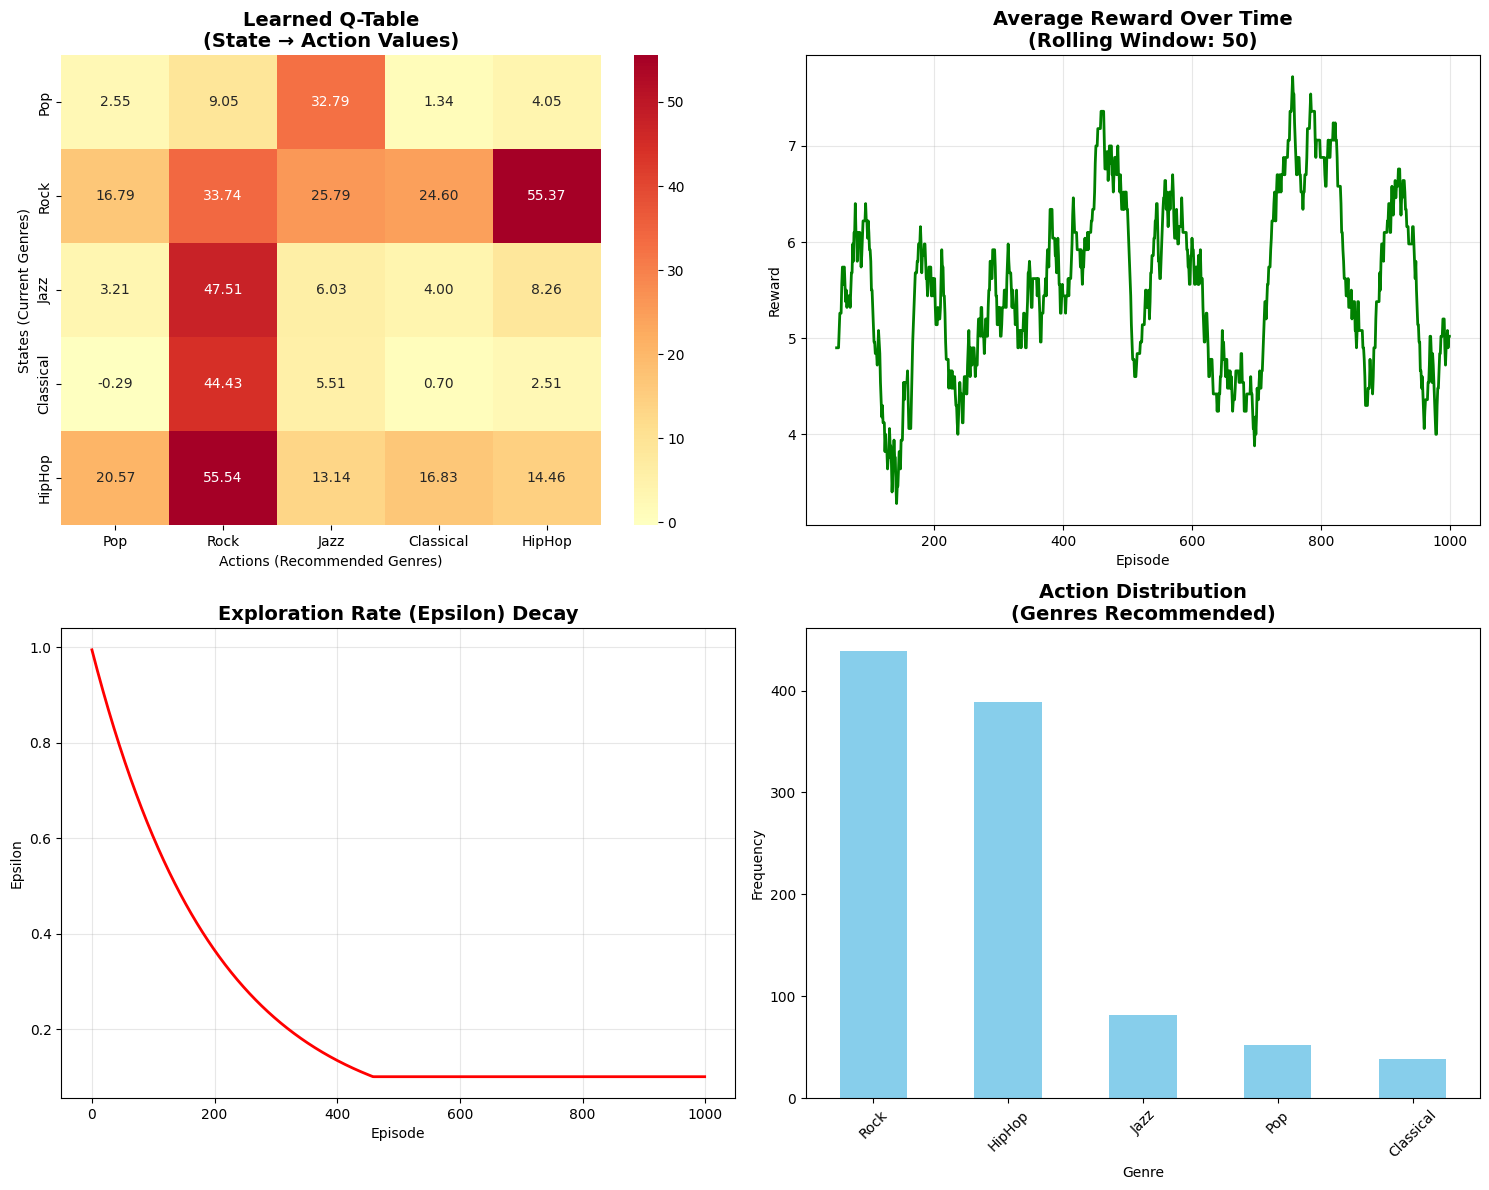


4. Sample Recommendations:
----------------------------------------
From        Pop → Top 3: [('Jazz', '32.79'), ('Rock', '9.05'), ('HipHop', '4.05')]
From       Rock → Top 3: [('HipHop', '55.37'), ('Rock', '33.74'), ('Jazz', '25.79')]
From       Jazz → Top 3: [('Rock', '47.51'), ('HipHop', '8.26'), ('Jazz', '6.03')]
From  Classical → Top 3: [('Rock', '44.43'), ('Jazz', '5.51'), ('HipHop', '2.51')]
From     HipHop → Top 3: [('Rock', '55.54'), ('Pop', '20.57'), ('Classical', '16.83')]

5. Analyzing Pop Lover Agent...


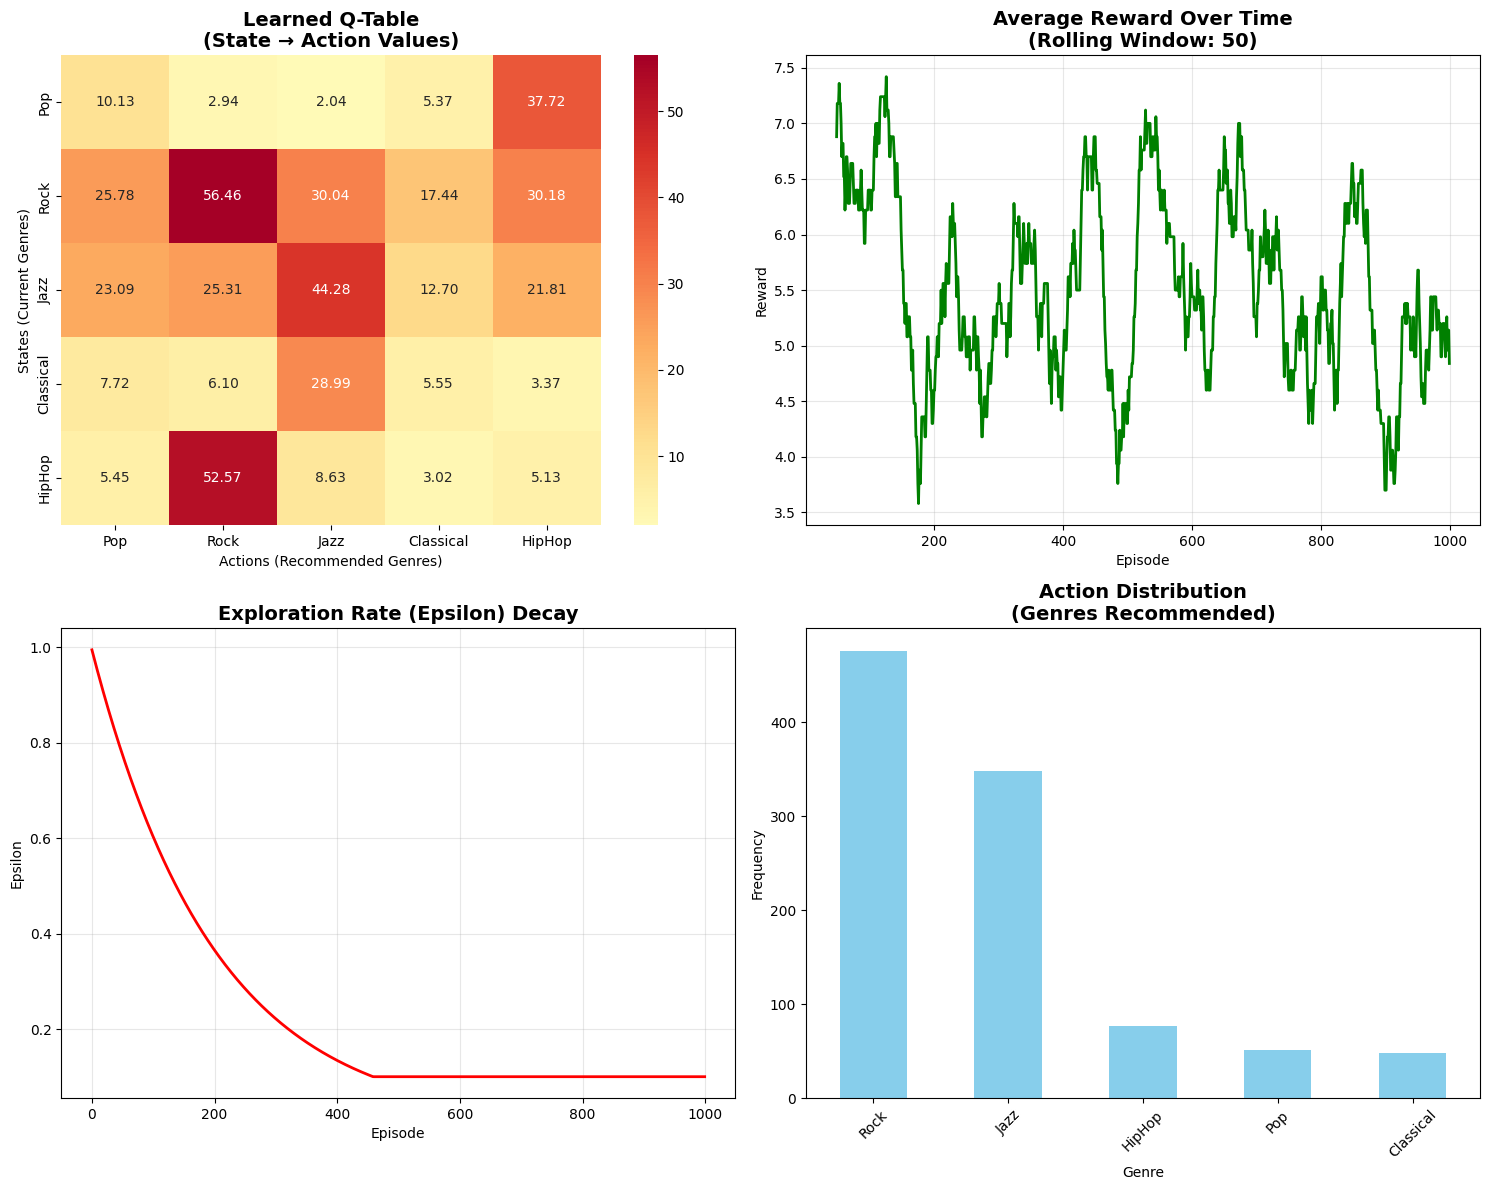


LEARNED RECOMMENDATION POLICY
When current genre is        Pop → Recommend     HipHop (Q-value:  37.72)
When current genre is       Rock → Recommend       Rock (Q-value:  56.46)
When current genre is       Jazz → Recommend       Jazz (Q-value:  44.28)
When current genre is  Classical → Recommend       Jazz (Q-value:  28.99)
When current genre is     HipHop → Recommend       Rock (Q-value:  52.57)

Detailed Q-values:
------------------------------------------------------------
From        Pop: {'Pop': np.float64(10.13), 'Rock': np.float64(2.94), 'Jazz': np.float64(2.04), 'Classical': np.float64(5.37), 'HipHop': np.float64(37.72)}
From       Rock: {'Pop': np.float64(25.78), 'Rock': np.float64(56.46), 'Jazz': np.float64(30.04), 'Classical': np.float64(17.44), 'HipHop': np.float64(30.18)}
From       Jazz: {'Pop': np.float64(23.09), 'Rock': np.float64(25.31), 'Jazz': np.float64(44.28), 'Classical': np.float64(12.7), 'HipHop': np.float64(21.81)}
From  Classical: {'Pop': np.float64(7.72), 'R

In [7]:
def main():
    print("🎵 MUSIC RECOMMENDATION SYSTEM USING Q-LEARNING 🎵")
    genres = ["Pop", "Rock", "Jazz", "Classical", "HipHop"]
    user_profiles = create_user_profiles()
    print("\n1. Training General Agent (Random User Behavior)...")
    general_agent = MusicRecommendationAgent(genres)
    general_agent.train(episodes=1000, verbose=True)
    print("\nGeneral Agent Results:")
    general_agent.print_policy()
    print("\n2. Comparing Agents with Different User Profiles...")
    results = compare_agents(genres, user_profiles, episodes=1000)
    print("\nPerformance Comparison:")
    print("-" * 40)
    for profile_name, result in results.items():
        print(f"{profile_name:>15}: {result['avg_final_reward']:6.2f} avg reward")
    print("\n3. Visualizing Learning Process...")
    general_agent.visualize_results()
    print("\n4. Sample Recommendations:")
    print("-" * 40)
    for genre in genres:
        recommendations = general_agent.get_recommendations(genre, top_k=3)
        print(f"From {genre:>10} → Top 3: {[(g, f'{v:.2f}') for g, v in recommendations]}")
    print("\n5. Analyzing Pop Lover Agent...")
    pop_agent = results["Pop Lover"]["agent"]
    pop_agent.visualize_results()
    pop_agent.print_policy()
    print("\n" + "="*60)
    print("ANALYSIS COMPLETE!")
    print("="*60)
    return general_agent, results

general_agent, comparison_results = main()